In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import time

In [4]:
BATCH_SIZE = 32
IMG_SIZE = 224

# Image transformations
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [5]:
data_dir = "/kaggle/input/cotton-plant-disease/Main dataset-20230209T170929Z-001/Main dataset"

In [6]:
# Load the entire dataset
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Split into train, val, and test sets (70% train, 15% val, 15% test)
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}, Test size: {len(test_dataset)}")
print(f"Classes: {full_dataset.classes}")

Train size: 2182, Val size: 467, Test size: 469
Classes: ['Aphids', 'Army worm', 'Bacterial Blight', 'Healthy', 'Powdery Mildew', 'Target spot']


In [7]:
class MHSA(nn.Module):
    def __init__(self, embed_dim, num_heads=8):
        super(MHSA, self).__init__()
        self.num_heads = num_heads
        self.embed_dim = embed_dim

        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.fc_out = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads)
        q, k, v = qkv.permute(2, 0, 3, 1, 4)  # [3, B, num_heads, N, dim]

        scores = torch.matmul(q, k.transpose(-2, -1)) / (C ** 0.5)
        attn = F.softmax(scores, dim=-1)
        
        x = torch.matmul(attn, v)
        x = x.transpose(1, 2).reshape(B, N, C)
        
        return self.fc_out(x)


In [8]:
class ShuffleNetV2MHSA(nn.Module):
    def __init__(self, num_classes=len(full_dataset.classes)):  
        super(ShuffleNetV2MHSA, self).__init__()
        
        # Load pretrained ShuffleNetV2 from torchvision models
        self.backbone = models.shufflenet_v2_x1_0(pretrained=True)
        
        # Remove the classifier head
        self.backbone.fc = nn.Identity()

        # MHSA attention block
        self.mhsa = MHSA(embed_dim=1024, num_heads=8)
        
        # Fully connected classifier head
        self.fc = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.backbone(x)  # Extract features
        x = x.unsqueeze(1)    # Reshape for MHSA
        x = self.mhsa(x)
        x = x.squeeze(1)
        x = self.fc(x)
        return x

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ShuffleNetV2MHSA(num_classes=len(full_dataset.classes)).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x1-5666bf0f80.pth
100%|██████████| 8.79M/8.79M [00:00<00:00, 129MB/s]


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [11]:
def train(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return running_loss / len(loader), accuracy



In [12]:
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return running_loss / len(loader), accuracy


In [13]:
EPOCHS = 10
train_loss_list, val_loss_list = [], []
train_acc_list, val_acc_list = [], []

start_time = time.time()

for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)

    print(f"Epoch [{epoch+1}/{EPOCHS}]")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%\n")

end_time = time.time()
print(f"Training Time: {(end_time - start_time):.2f} seconds")


Epoch [1/10]
Train Loss: 0.7752, Train Acc: 71.81%
Val Loss: 0.1309, Val Acc: 96.79%

Epoch [2/10]
Train Loss: 0.2493, Train Acc: 93.03%
Val Loss: 0.1285, Val Acc: 96.15%

Epoch [3/10]
Train Loss: 0.1251, Train Acc: 96.98%
Val Loss: 0.0722, Val Acc: 97.22%

Epoch [4/10]
Train Loss: 0.1546, Train Acc: 95.97%
Val Loss: 0.2454, Val Acc: 91.86%

Epoch [5/10]
Train Loss: 0.1931, Train Acc: 94.87%
Val Loss: 0.1151, Val Acc: 95.29%

Epoch [6/10]
Train Loss: 0.2741, Train Acc: 94.68%
Val Loss: 1.8792, Val Acc: 93.15%

Epoch [7/10]
Train Loss: 0.2846, Train Acc: 93.68%
Val Loss: 0.1452, Val Acc: 95.07%

Epoch [8/10]
Train Loss: 0.1428, Train Acc: 96.47%
Val Loss: 0.0944, Val Acc: 97.22%

Epoch [9/10]
Train Loss: 0.1545, Train Acc: 95.00%
Val Loss: 0.0764, Val Acc: 97.43%

Epoch [10/10]
Train Loss: 0.0939, Train Acc: 97.43%
Val Loss: 0.1631, Val Acc: 96.15%

Training Time: 1115.55 seconds


In [15]:
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"Test Accuracy: {test_acc:.2f}%")

Test Accuracy: 96.38%


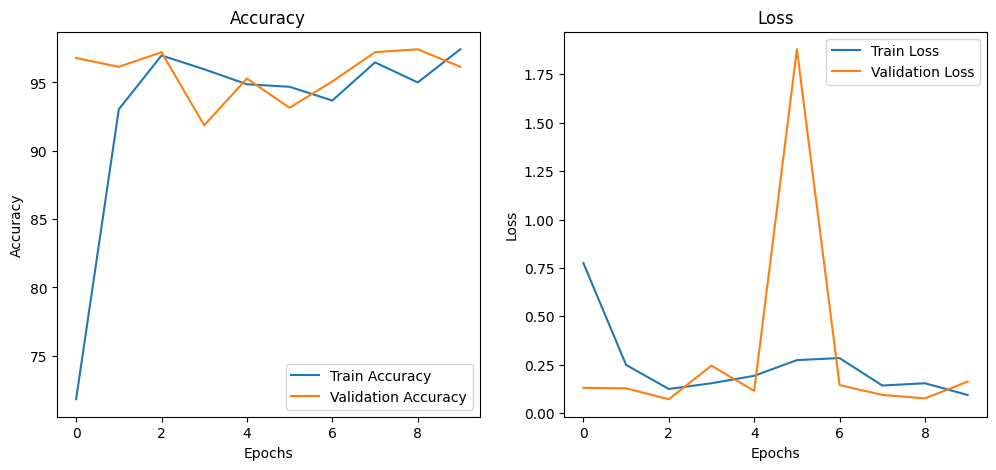

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy Plot
ax[0].plot(train_acc_list, label='Train Accuracy')
ax[0].plot(val_acc_list, label='Validation Accuracy')
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

# Loss Plot
ax[1].plot(train_loss_list, label='Train Loss')
ax[1].plot(val_loss_list, label='Validation Loss')
ax[1].set_title('Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()

plt.show()

In [1]:
# Import Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import time

# -------------------------------------
# 📊 Data Loading and Preprocessing
BATCH_SIZE = 32
IMG_SIZE = 224

# Image transformations
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 🔥 Dataset path
data_dir = "/kaggle/input/cotton-plant-disease/Main dataset-20230209T170929Z-001/Main dataset"

# Load the entire dataset
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Split into train, val, and test sets (70% train, 15% val, 15% test)
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}, Test size: {len(test_dataset)}")
print(f"Classes: {full_dataset.classes}")


Train size: 2182, Val size: 467, Test size: 469
Classes: ['Aphids', 'Army worm', 'Bacterial Blight', 'Healthy', 'Powdery Mildew', 'Target spot']


In [2]:
class MHSA(nn.Module):
    def __init__(self, embed_dim, num_heads=8):
        super(MHSA, self).__init__()
        self.num_heads = num_heads
        self.embed_dim = embed_dim

        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.fc_out = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        B, N, C = x.shape  # Batch, Num Patches, Channels
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads)
        q, k, v = qkv.permute(2, 0, 3, 1, 4)  # [3, B, num_heads, N, dim]

        scores = torch.matmul(q, k.transpose(-2, -1)) / (C ** 0.5)
        attn = F.softmax(scores, dim=-1)
        
        x = torch.matmul(attn, v)
        x = x.transpose(1, 2).reshape(B, N, C)
        
        return self.fc_out(x)


In [3]:
class ViTWithMHSA(nn.Module):
    def __init__(self, num_classes=len(full_dataset.classes)):
        super(ViTWithMHSA, self).__init__()
        
        # Load pretrained Vision Transformer (ViT) model
        self.backbone = models.vit_b_16(pretrained=True)

        # Remove the original classifier head
        self.backbone.heads = nn.Identity()

        # Add MHSA block
        self.mhsa = MHSA(embed_dim=768, num_heads=8)  # ViT base dim=768

        # Fully connected classifier
        self.fc = nn.Sequential(
            nn.Linear(768, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.backbone(x)  # Extract features from ViT
        x = x.unsqueeze(1)    # Reshape for MHSA
        x = self.mhsa(x)
        x = x.squeeze(1)
        x = self.fc(x)
        return x

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViTWithMHSA(num_classes=len(full_dataset.classes)).to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 204MB/s]  


In [5]:
def train(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return running_loss / len(loader), accuracy


def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return running_loss / len(loader), accuracy


In [6]:
EPOCHS = 10
train_loss_list, val_loss_list = [], []
train_acc_list, val_acc_list = [], []

start_time = time.time()

for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)

    print(f"Epoch [{epoch+1}/{EPOCHS}]")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%\n")

end_time = time.time()
print(f"Training Time: {(end_time - start_time):.2f} seconds")


Epoch [1/10]
Train Loss: 1.7828, Train Acc: 21.68%
Val Loss: 1.6507, Val Acc: 28.69%

Epoch [2/10]
Train Loss: 1.5963, Train Acc: 35.93%
Val Loss: 1.5404, Val Acc: 35.33%

Epoch [3/10]
Train Loss: 1.4966, Train Acc: 40.60%
Val Loss: 1.4304, Val Acc: 40.69%

Epoch [4/10]
Train Loss: 1.4287, Train Acc: 43.31%
Val Loss: 1.4440, Val Acc: 41.76%

Epoch [5/10]
Train Loss: 1.3929, Train Acc: 45.74%
Val Loss: 1.4232, Val Acc: 40.90%

Epoch [6/10]
Train Loss: 1.3220, Train Acc: 47.85%
Val Loss: 1.4309, Val Acc: 43.25%

Epoch [7/10]
Train Loss: 1.2219, Train Acc: 53.35%
Val Loss: 1.1523, Val Acc: 54.60%

Epoch [8/10]
Train Loss: 1.1818, Train Acc: 54.45%
Val Loss: 1.2144, Val Acc: 49.68%

Epoch [9/10]
Train Loss: 1.1762, Train Acc: 54.17%
Val Loss: 1.0005, Val Acc: 60.17%

Epoch [10/10]
Train Loss: 1.0579, Train Acc: 61.04%
Val Loss: 1.2274, Val Acc: 51.39%

Training Time: 1068.00 seconds


In [8]:
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"Test Accuracy: {test_acc:.2f}%")


Test Accuracy: 52.24%


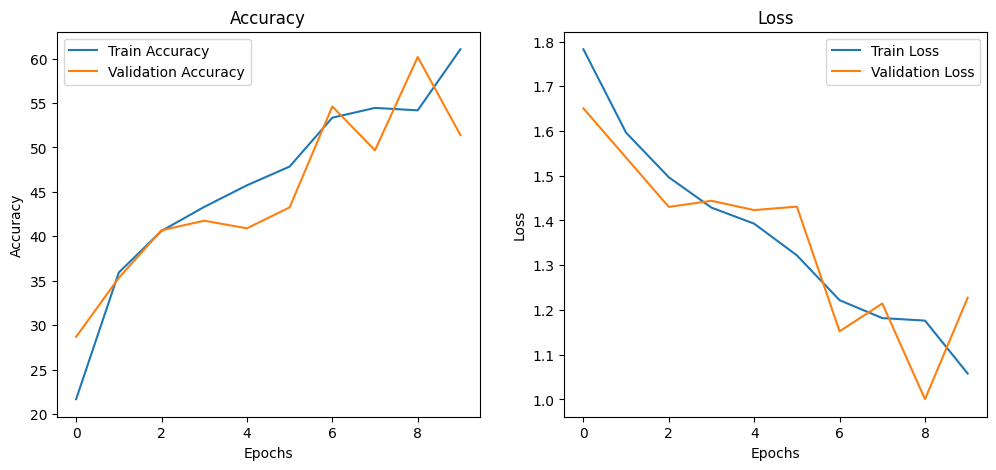

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy Plot
ax[0].plot(train_acc_list, label='Train Accuracy')
ax[0].plot(val_acc_list, label='Validation Accuracy')
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

# Loss Plot
ax[1].plot(train_loss_list, label='Train Loss')
ax[1].plot(val_loss_list, label='Validation Loss')
ax[1].set_title('Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()

plt.show()

In [14]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import os
import numpy as np

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Pre-trained ViT Model
vit_model = models.vit_b_16(pretrained=True).to(device)
vit_model.eval()

# Multihead Self-Attention Layer
mhsa = nn.MultiheadAttention(embed_dim=768, num_heads=8).to(device)

# Feature Extraction Function
def extract_vit_mhsa_features(image_path, model, mhsa, transform, device):
    """Extracts ViT + MHSA attention features with proper reshaping"""
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    with torch.no_grad():
        # Forward pass through ViT
        features = model.conv_proj(image)  # (B, C, H, W)
        B, C, H, W = features.shape

        # Reshape for MHSA (B, num_patches, embed_dim)
        features = features.flatten(2).transpose(1, 2)  # (B, num_patches, embed_dim)

        # Create query, key, and value tensors (B, num_patches, embed_dim)
        query = key = value = features

        # Pass through MHSA
        attn_output, attn_weights = mhsa(query, key, value)

        # Flatten and return the features
        features = attn_output.mean(dim=1)  # Average over the patches
        return features.cpu().numpy().flatten()

# Preprocessing Transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset Path
image_dir = '/kaggle/input/cotton-plant-disease/Main dataset-20230209T170929Z-001/Main dataset'

# Extracting Features
features = []
labels = []

# Iterate through classes
for label, class_dir in enumerate(os.listdir(image_dir)):
    class_path = os.path.join(image_dir, class_dir)

    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)

        feature = extract_vit_mhsa_features(img_path, vit_model, mhsa, transform, device)

        features.append(feature)
        labels.append(label)

# Convert to NumPy arrays
X = np.array(features)
y = np.array(labels)

print(f"Extracted MHSA features shape: {X.shape}")


Extracted MHSA features shape: (3118, 768)


In [15]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SVM Classifier
svm = SVC(kernel='rbf', C=1.0)
svm.fit(X_train, y_train)

# Predictions
y_pred = svm.predict(X_test)

# Evaluation
print("SVM Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


SVM Accuracy: 0.46153846153846156
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.68      0.65       123
           1       0.36      0.64      0.46       102
           2       0.52      0.21      0.30       106
           3       0.53      0.56      0.54        98
           4       0.27      0.18      0.21        91
           5       0.46      0.44      0.45       104

    accuracy                           0.46       624
   macro avg       0.46      0.45      0.43       624
weighted avg       0.47      0.46      0.44       624



In [16]:
import xgboost as xgb

# XGBoost Classifier
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1)
xgb_model.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluation
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))


XGBoost Accuracy: 0.7660256410256411
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.76      0.80       123
           1       0.64      0.82      0.72       102
           2       0.77      0.75      0.76       106
           3       0.76      0.79      0.77        98
           4       0.74      0.79      0.77        91
           5       0.90      0.69      0.78       104

    accuracy                           0.77       624
   macro avg       0.78      0.77      0.77       624
weighted avg       0.78      0.77      0.77       624



In [17]:
from sklearn.neural_network import MLPClassifier

# MLP Classifier
mlp = MLPClassifier(hidden_layer_sizes=(512, 256), max_iter=500, random_state=42)
mlp.fit(X_train, y_train)

# Predictions
y_pred_mlp = mlp.predict(X_test)

# Evaluation
print("MLP Accuracy:", accuracy_score(y_test, y_pred_mlp))
print("Classification Report:\n", classification_report(y_test, y_pred_mlp))


MLP Accuracy: 0.7772435897435898
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.76      0.84       123
           1       0.73      0.81      0.77       102
           2       0.80      0.76      0.78       106
           3       0.78      0.74      0.76        98
           4       0.62      0.84      0.71        91
           5       0.84      0.75      0.79       104

    accuracy                           0.78       624
   macro avg       0.78      0.78      0.78       624
weighted avg       0.79      0.78      0.78       624



In [18]:
!pip install timm


In [19]:
import torch
import torch.nn as nn
from timm import create_model
from torchvision import transforms
from PIL import Image
import os
import numpy as np

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load EfficientNet-B0 model
efficientnet = create_model('efficientnet_b0', pretrained=True).to(device)
efficientnet.eval()

# Multi-Head Self-Attention Layer
mhsa = nn.MultiheadAttention(embed_dim=1280, num_heads=8).to(device)

# Feature Extraction Function
def extract_efficientnet_mhsa_features(image_path, model, mhsa, transform, device):
    """Extracts EfficientNet + MHSA features with proper reshaping"""
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    with torch.no_grad():
        # Forward pass through EfficientNet
        features = model.forward_features(image)  # Extract features
        B, C, H, W = features.shape  # (B, C, H, W)

        # Reshape for MHSA
        features = features.flatten(2).transpose(1, 2)  # (B, num_patches, embed_dim)

        # Apply MHSA
        query = key = value = features
        attn_output, attn_weights = mhsa(query, key, value)

        # Average attention output across patches
        features = attn_output.mean(dim=1)  # (B, embed_dim)
        
        return features.cpu().numpy().flatten()

# Preprocessing Transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset Path
image_dir = '/kaggle/input/cotton-plant-disease/Main dataset-20230209T170929Z-001/Main dataset'

# Extracting Features
features = []
labels = []

# Iterate through classes
for label, class_dir in enumerate(os.listdir(image_dir)):
    class_path = os.path.join(image_dir, class_dir)

    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)

        feature = extract_efficientnet_mhsa_features(img_path, efficientnet, mhsa, transform, device)

        features.append(feature)
        labels.append(label)

# Convert to NumPy arrays
X = np.array(features)
y = np.array(labels)

print(f"Extracted MHSA features shape: {X.shape}")


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Extracted MHSA features shape: (3118, 1280)


In [20]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SVM Classifier
svm = SVC(kernel='rbf', C=1.0)
svm.fit(X_train, y_train)

# Predictions
y_pred = svm.predict(X_test)

# Evaluation
print("\n🔥 SVM Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))



🔥 SVM Accuracy: 0.9855769230769231
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       123
           1       1.00      1.00      1.00       102
           2       0.96      0.99      0.98       106
           3       1.00      0.98      0.99        98
           4       0.98      0.95      0.96        91
           5       0.98      1.00      0.99       104

    accuracy                           0.99       624
   macro avg       0.99      0.98      0.98       624
weighted avg       0.99      0.99      0.99       624



In [21]:
import xgboost as xgb

# XGBoost Classifier
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1)
xgb_model.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluation
print("\n🔥 XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))



🔥 XGBoost Accuracy: 0.9567307692307693
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97       123
           1       0.97      0.99      0.98       102
           2       0.94      0.96      0.95       106
           3       0.98      0.95      0.96        98
           4       0.92      0.93      0.93        91
           5       0.94      0.94      0.94       104

    accuracy                           0.96       624
   macro avg       0.96      0.96      0.96       624
weighted avg       0.96      0.96      0.96       624



In [22]:
from sklearn.neural_network import MLPClassifier

# MLP Classifier
mlp = MLPClassifier(hidden_layer_sizes=(512, 256), max_iter=500, random_state=42)
mlp.fit(X_train, y_train)

# Predictions
y_pred_mlp = mlp.predict(X_test)

# Evaluation
print("\n🔥 MLP Accuracy:", accuracy_score(y_test, y_pred_mlp))
print("Classification Report:\n", classification_report(y_test, y_pred_mlp))



🔥 MLP Accuracy: 0.9791666666666666
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       123
           1       0.99      1.00      1.00       102
           2       0.96      0.96      0.96       106
           3       0.99      0.99      0.99        98
           4       0.99      0.95      0.97        91
           5       0.97      0.99      0.98       104

    accuracy                           0.98       624
   macro avg       0.98      0.98      0.98       624
weighted avg       0.98      0.98      0.98       624



In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from timm import create_model
import os

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Define EfficientNet with MHSA
class EfficientNetMHSA(nn.Module):
    def __init__(self, num_classes=6):  # 5 classes + Healthy
        super(EfficientNetMHSA, self).__init__()

        # Pretrained EfficientNet backbone
        self.efficientnet = create_model('efficientnet_b0', pretrained=True)
        
        # Remove the final classification layer
        self.efficientnet = nn.Sequential(*list(self.efficientnet.children())[:-2])

        # Multi-Head Self-Attention Layer
        self.mhsa = nn.MultiheadAttention(embed_dim=1280, num_heads=8)

        # Fully Connected Layers for Classification
        self.fc1 = nn.Linear(1280, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        # EfficientNet Feature Extraction
        x = self.efficientnet(x)  # (B, 1280, 7, 7)

        # Reshape for MHSA
        B, C, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)  # (B, num_patches, embed_dim)
        
        # MHSA
        x = x.permute(1, 0, 2)  # (num_patches, B, embed_dim)
        attn_output, _ = self.mhsa(x, x, x)
        x = attn_output.permute(1, 0, 2).mean(dim=1)  # (B, embed_dim)

        # Classification
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Dataset path
dataset_path = '/kaggle/input/cotton-plant-disease/Main dataset-20230209T170929Z-001/Main dataset'

# Image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load dataset
dataset = ImageFolder(root=dataset_path, transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model initialization
num_classes = len(dataset.classes)
model = EfficientNetMHSA(num_classes=num_classes).to(device)


Using device: cuda


In [24]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


In [25]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import time

# Training Loop
epochs = 10
best_acc = 0.0

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    start_time = time.time()

    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if (i + 1) % 10 == 0:
            print(f"Epoch [{epoch + 1}/{epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    scheduler.step()

    # Evaluation
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    
    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), "best_efficientnet_mhsa.pth")
    
    print(f"Epoch {epoch + 1} completed in {time.time() - start_time:.2f}s. Accuracy: {acc:.4f}")


Epoch [1/10], Step [10/78], Loss: 0.1666
Epoch [1/10], Step [20/78], Loss: 0.5862
Epoch [1/10], Step [30/78], Loss: 0.0823
Epoch [1/10], Step [40/78], Loss: 0.7244
Epoch [1/10], Step [50/78], Loss: 0.2400
Epoch [1/10], Step [60/78], Loss: 0.4040
Epoch [1/10], Step [70/78], Loss: 0.0411
Epoch 1 completed in 39.66s. Accuracy: 0.9487
Epoch [2/10], Step [10/78], Loss: 0.4124
Epoch [2/10], Step [20/78], Loss: 0.5314
Epoch [2/10], Step [30/78], Loss: 0.3249
Epoch [2/10], Step [40/78], Loss: 0.2796
Epoch [2/10], Step [50/78], Loss: 0.5039
Epoch [2/10], Step [60/78], Loss: 0.7976
Epoch [2/10], Step [70/78], Loss: 0.2084
Epoch 2 completed in 40.35s. Accuracy: 0.8878
Epoch [3/10], Step [10/78], Loss: 1.3675
Epoch [3/10], Step [20/78], Loss: 0.6681
Epoch [3/10], Step [30/78], Loss: 2.4714
Epoch [3/10], Step [40/78], Loss: 0.4216
Epoch [3/10], Step [50/78], Loss: 0.3278
Epoch [3/10], Step [60/78], Loss: 0.3324
Epoch [3/10], Step [70/78], Loss: 0.4119
Epoch 3 completed in 40.37s. Accuracy: 0.9215
E

<ipython-input-26-d0fc0a67298f>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_efficientnet_mhsa.pth"))


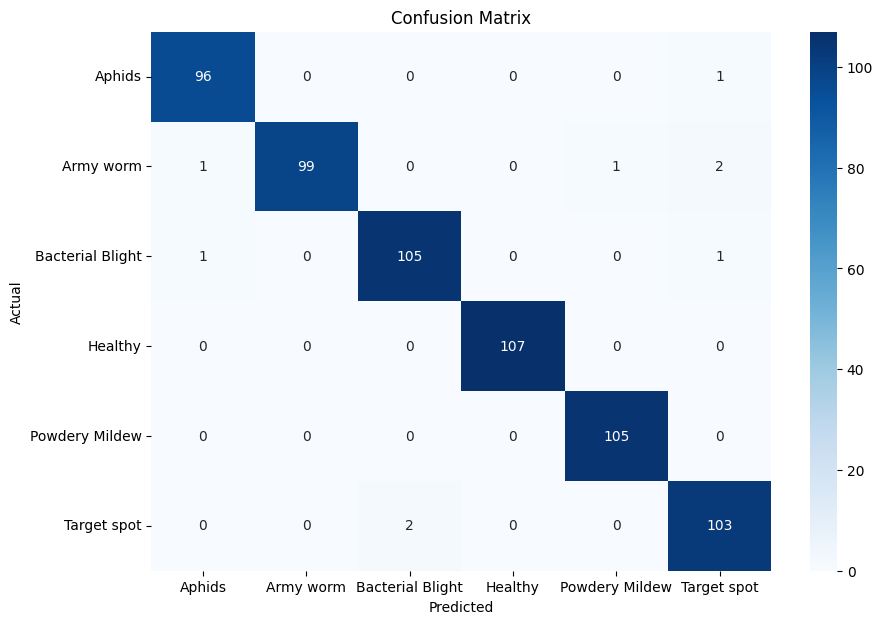

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98        97
           1       1.00      0.96      0.98       103
           2       0.98      0.98      0.98       107
           3       1.00      1.00      1.00       107
           4       0.99      1.00      1.00       105
           5       0.96      0.98      0.97       105

    accuracy                           0.99       624
   macro avg       0.99      0.99      0.99       624
weighted avg       0.99      0.99      0.99       624



In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load the best model
model.load_state_dict(torch.load("best_efficientnet_mhsa.pth"))
model.eval()

# Collect predictions and labels
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(all_labels, all_preds))
